In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import time

In [2]:
def poisson(exp, n):
    return (math.pow(exp, n) / math.factorial(n)) * math.exp(-exp)

In [25]:
class CarRental:
    def __init__(self, max_car=20, max_move=5, cost=2, reward=10, cost_parking=4, gamma=0.9, theta=0.01,
                rent_exp_first_loc=3, rent_exp_second_loc=4, return_exp_first_loc=3, return_exp_second_loc=2, mode='example'):
        self.max_car = max_car
        self.max_move = max_move
        self.reward = reward
        self.cost = cost 
        self.cost_parking = cost_parking # exercise 4.7
        self.rent_exp_first_loc = rent_exp_first_loc
        self.rent_exp_second_loc = rent_exp_second_loc
        self.return_exp_first_loc = return_exp_first_loc
        self.return_exp_second_loc = return_exp_second_loc
        self.gamma = gamma
        self.theta = theta
        self.mode = mode

    def reset(self):
        self.actions = np.arange(-self.max_move, self.max_move + 1) # numer of cars moved from location 1 to location 2
        self.state_values =  np.zeros([self.max_car + 1, self.max_car + 1])
        self.policy = np.zeros([self.max_car + 1, self.max_car + 1], dtype=int)
        self.policies = [self.policy.copy()]

    def _get_action_space(self, state):
        first_cars, second_cars = state
        actions = [0]

        for action in self.actions:
            new_first_cars, new_second_cars = first_cars - action, second_cars + action
            if new_first_cars >=0 and new_first_cars <= self.max_car and new_second_cars >=0 and new_second_cars <= self.max_car:
                actions.append(action)
        return set(actions) # return possible actions

    def step(self, state, action):
        first_cars, second_cars = state
        first_cars -= action
        second_cars += action
        value = 0

        if self.mode == 'example':
            cost = self.cost * abs(action)
        else: # exercise 4.7
            if action > 0 :
                action -= 1 # an employee shuttle one car from the first location to the second location for free
            cost = self.cost * abs(action) + (max(0, first_cars - self.max_car) + max(0, second_cars - self.max_car)) * self.cost_parking

        prob_sum_rent_first = 0
        for car_rent_first in range(first_cars + 1):
            if car_rent_first != first_cars:
                prob_rent_first = poisson(self.rent_exp_first_loc, car_rent_first)
                prob_sum_rent_first += prob_rent_first
            else:
                prob_rent_first = 1 - prob_sum_rent_first
            reward_rent_first = car_rent_first * self.reward

            prob_sum_return_first = 0
            max_return_first = self.max_car - (first_cars - car_rent_first)
            for car_return_first in range(max_return_first + 1):
                if car_return_first != max_return_first:
                    prob_return_first = poisson(self.return_exp_first_loc, car_return_first)
                    prob_sum_return_first += prob_return_first
                else:
                    prob_return_first = 1 - prob_sum_return_first

                prob_sum_rent_second = 0   
                for car_rent_second in range(second_cars + 1):
                    if car_rent_second != second_cars:
                        prob_rent_second = poisson(self.rent_exp_second_loc, car_rent_second)
                        prob_sum_rent_second += prob_rent_second
                    else:
                        prob_rent_second = 1 - prob_sum_rent_second
                    reward_rent_second = car_rent_second * self.reward

                    prob_sum_return_second = 0
                    max_return_second = self.max_car - (second_cars - car_rent_second)
                    for car_return_second in range(max_return_second + 1):
                        if car_return_second != max_return_second:
                            prob_return_second = poisson(self.return_exp_second_loc, car_return_second)
                            prob_sum_return_second += prob_return_second
                        else:
                            prob_return_second = 1 - prob_sum_return_second

                        next_first_cars = first_cars - car_rent_first + car_return_first
                        next_second_cars = second_cars - car_rent_second + car_return_second
                        value += prob_rent_first * prob_return_first * prob_rent_second * prob_return_second * \
                                (reward_rent_first + reward_rent_second - cost + self.gamma * self.state_values[next_first_cars, next_second_cars])
        return value

    def policy_evaluation(self):
        while True:
            delta = 0
            for car_first in range(self.max_car + 1):
                for car_second in range(self.max_car + 1):
                    old_state_values = self.state_values.copy()
                    value = self.step([car_first, car_second], self.policy[car_first, car_second])
                    self.state_values[car_first, car_second] = value
                    delta = max(delta, abs(old_state_values[car_first, car_second] - value))
            print('\rdelta: {}'.format(delta), end='')
            if delta < self.theta:
                break

    def policy_improvement(self):
        policy_stable = True
        for car_first in range(self.max_car + 1):
            for car_second in range(self.max_car + 1):
                old_action = self.policy[car_first, car_second]
                state = [car_first, car_second]
                action_space = self._get_action_space(state)
                state_action_values = {action: self.step(state, action) for action in action_space}
                max_actions = [a for a, v in state_action_values.items() if v == max(list(state_action_values.values()))]
                self.policy[car_first, car_second] = np.random.choice(max_actions)
                if old_action not in max_actions:
                    policy_stable = False
        self.policies.append(self.policy.copy())
        return policy_stable

In [24]:
def example_4_2():
    jacks_car_rental = CarRental()
    jacks_car_rental.reset()

    count = 0
    while True:
        print('\n{} iteration: {}'.format(time.strftime('%H:%M:%S', time.localtime()), count + 1))
        jacks_car_rental.policy_evaluation()
        policy_stable = jacks_car_rental.policy_improvement()
        if policy_stable:
            break
        count += 1
    return jacks_car_rental.policies, jacks_car_rental.state_values

def exercise_4_7():
    jacks_car_rental = CarRental(max_car=10, mode='exercise')
    jacks_car_rental.reset()
    count = 0
    while True:
        print('\n{} iteration: {}'.format(time.strftime('%H:%M:%S', time.localtime()), count + 1))
        jacks_car_rental.policy_evaluation()
        policy_stable = jacks_car_rental.policy_improvement()
        if policy_stable:
            break
        count += 1
    return jacks_car_rental.policies, jacks_car_rental.state_values

In [26]:
policies_example, state_values_example = example_4_2()


16:54:40 iteration: 1
delta: 0.009801332242716398
17:03:47 iteration: 2
delta: 0.009096430770966893
17:10:09 iteration: 3
delta: 0.009451139759676153
17:15:27 iteration: 4
delta: 0.007193644671815491
17:18:18 iteration: 5
delta: 0.007052986426629104

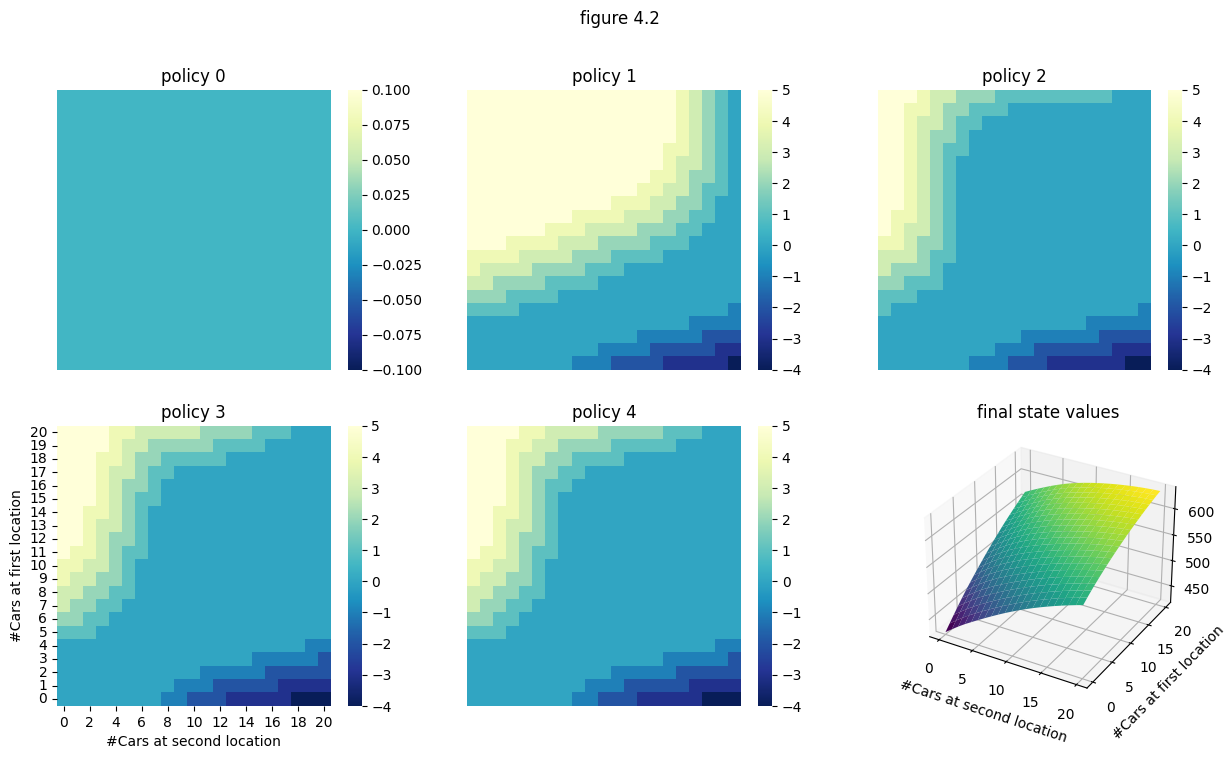

In [37]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))

for i in range(5):
    sub_ax = ax[i//3, i%3]
    sns.heatmap(np.flipud(policies_example[i]), cmap='YlGnBu_r', ax=sub_ax, yticklabels=list(reversed(range(len(policies_example[i])))))
    sub_ax.set_title('policy {}'.format(i))
    if i == 3:
        sub_ax.set_xlabel('#Cars at second location')
        sub_ax.set_ylabel('#Cars at first location')
    else:
        sub_ax.set_xticks([])
        sub_ax.set_yticks([])

ax[1, 2].remove()
ax[1, 2] = fig.add_subplot(2, 3, 6, projection='3d')
x = np.outer(np.arange(len(state_values_example)), np.ones(len(state_values_example)))
y = x.copy().T
ax[1, 2].plot_surface(x, y, state_values_example, cmap ='viridis')
ax[1, 2].set_xlabel('#Cars at second location')
ax[1, 2].set_ylabel('#Cars at first location')
ax[1, 2].set_title('final state values')
plt.suptitle('figure 4.2')
plt.show()


In [38]:
policies_exercise, state_values_exercise = exercise_4_7()


20:09:44 iteration: 1
delta: 0.008917143829762608
20:09:57 iteration: 2
delta: 0.009037296218252777
20:10:07 iteration: 3
delta: 0.008531785381819645
20:10:14 iteration: 4
delta: 0.009294146294337224

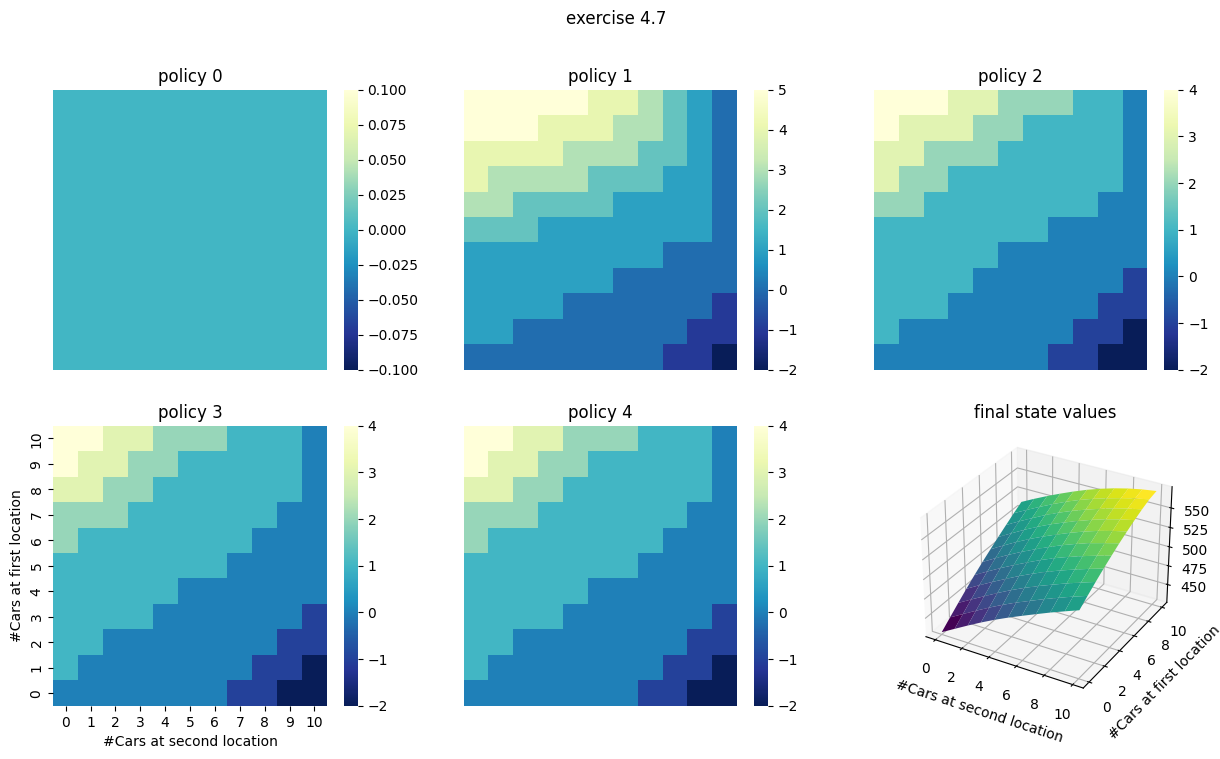

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))

for i in range(5):
    sub_ax = ax[i//3, i%3]
    sns.heatmap(np.flipud(policies_exercise[i]), cmap='YlGnBu_r', ax=sub_ax, yticklabels=list(reversed(range(len(policies_exercise[i])))))
    sub_ax.set_title('policy {}'.format(i))
    if i == 3:
        sub_ax.set_xlabel('#Cars at second location')
        sub_ax.set_ylabel('#Cars at first location')
    else:
        sub_ax.set_xticks([])
        sub_ax.set_yticks([])

ax[1, 2].remove()
ax[1, 2] = fig.add_subplot(2, 3, 6, projection='3d')
x = np.outer(np.arange(len(state_values_exercise)), np.ones(len(state_values_exercise)))
y = x.copy().T
ax[1, 2].plot_surface(x, y, state_values_exercise, cmap ='viridis')
ax[1, 2].set_xlabel('#Cars at second location')
ax[1, 2].set_ylabel('#Cars at first location')
ax[1, 2].set_title('final state values')
plt.suptitle('exercise 4.7')
plt.show()